## FIT5226 Assignment 1 Team (TBA)
MEMBERS :
- Michelle Adeline (31989101)
- Pay Quan Bi (31248403)
- Chan Jia Zheng (32223315)
- Zoe Low Pei Ee (31989985)

TUTOR : Dr. Fuad Noman

## Imports

In [1]:
# loads classes and functions to implement task
from modules.env import Environment
from modules.history import History
from modules.agent_movement import Agent, Movement, MoveDown, MoveLeft, MoveRight, MoveUp
from modules.reward import Reward
from modules.engine import Engine
from modules.qlearning import QLearning
from modules.policies import Boltzmann, EpsilonGreedy, Pursuit, MonteCarlo
from modules.losses import L2_Loss, L1_Loss
from modules.constants import *
from modules.viz import Visualization
from modules.search import hyperparam_search
from modules.grid_test import test_grids, test_grids_viz

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
%matplotlib inline

## Environment

To implement the GRID WORLD that is scalable and generalisable, Object-Oriented Programming (OOP) concepts are applied in the design. To follow Separation of Concerns, our design is modularised and consists of the following 2 main classes:
- `Environment` (A class for generating the grids and simulate the environment) located [**here**](modules/env.py)
- `Agent` (A class for mimicking the agent to perform actions in the environment) located [**here**](modules/agent_movement.py)

To modularize the components, supported classes are created to allow flexibility and scalability. The following shows some of the supported classes.
- `History` (A class used to keep track of the states, actions, rewards in each episode) located [**here**](modules/history.py)
- `Movement` (A class used for representing the action space) located [**here**](modules/agent_movement.py)

In order to create a scalable solution, we have listed the main measures taken to implement this below:
- `Environment` class
    - accepts a `grid_size` parameter which is used to create a grid world of any (width, height)
    - `loc_agent`, `loc_a`, `loc_b` as optional parameters, if any of the locations are provided then they are fixed throughout the task, thus the code is generalizable to fixed agent or A locations, as well as randomly generated locations
    - allows resetting (see `reset` method) which will re-generate the grid world with random agent and A locations (if they are not fixed) while also allowing the option to fix the agent and A locations for a particular run
- `Agent` class
    - has an `env` attribute which allows it to stay in sync with the environment configuration, possible movements are ascertained by the environment so that the agent automatically adapts to any grid world

This gives an overview of the design which is greatly modularized to ensure great scalability. For details of the implementation, refer to the implementation files.

## Task Description

The Q-agent must learn to navigate in a grid world, it succeeds in its task by first picking up the item at location A (by simply reaching location A), and delivering it to location B (by simply reaching location B *after* picking up item at A). It must be able to perform this task regardless of the initial location of the agent or location A. However, location B is fixed at the bottom right corner of the grid world.

### State space
In order to be able to reuse learned q-values between episodes, we have formulated our state as the (x,y) position relative to the target (A/B). 

Let (u, v) be state.  
Let (x, y) be grid size.  

Based on our implementation:
1. u is the horizontal position of agent with respect to the target (A/B). u ∈ (-(x-1), (x-1))
2. v is the vertical position of the agent with respect to the target (A/B). v ∈ (-(y-1), (y-1))
3. Position of target relative to itself is at (0 ,0) 

Note that the target is initialized to A at the beginning of an episode and is changed to B once the agent picks up the item at A, thus our state automatically adapts to this change in target.

For an example of why this is effective, if we imagine that the agent is directly to the left of location A, the best action will always be to move right and pick up the item at A regardless of their actual grid positions (i.e. even if the agent and location A are in the left, center, right or anywhere else in the grid world, the best action is still to move right). Our engineered state reflects this by treating all these scenarios with the same state (-1,0) which tells the agent that it is 1 cell to the left of the target.

### Action space
Our Q-Agent can move in the four cardinal directions -- Up, Down, Left, Right.

However, if it is adjacent to one or more of the four corners of the grid world, then its movements are limited. For example, if it is adjacent to the right corner of the grid world, it cannot move Right (since then it would move off the map!)

Note that the following measure has been taken to implement a scalable solution:
- `Movement` class
    - agents will check for subclasses of `Movement`, thus if we want to add another movement to the task, we can simply inherit `Movement` class and all agents will be able to use this movement without changing the `Agent` code at all!

In [3]:
# set seed for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
history = History() # initialize train history
eval_history = History() # initialize evaluation history
env = Environment(GRID_SIZE, history, loc_b=LOC_B) # create a 5x5 grid world with fixed Location B at the bottom right corner
agent = Agent(env) # create an agent located in the environment

## Q-Learning

In general, Q-learning requires behavioural policy to guide the learning of the target policy. The update rule of Q-learning could be summarized in the equation below.
\begin{align*}
    Q(s_t, a_t) &\leftarrow{} Q(s_t, a_t) + \alpha (R_{t+1} + \gamma Q(s_{t+1}, a^{\pi}) - Q(s_{t}, a_{t}))
\end{align*}
where $a_t$ is chosen from the behavioural policy and $a^{\pi}$ is obtained from the target policy.

In our implementation, the target policy is a greedy policy that constantly exploits the learnt q-value, $Q(s, a)$, to follow the ideal path to the point A and B. With that, the update rule is refined to be as follows.
\begin{align*}
    Q(s_t, a_t) &\leftarrow{} (1 - \alpha) * Q(s_t, a_t) + \alpha (R_{t+1} + \gamma \max_a Q(s_{t+1}, a))
\end{align*}
where $a$ is the possible actions performed by agent at state, $s_{t+1}$.

### Policy
Note that $a_t$ in the above update rule is determined using the behavioral policy, which in most cases is epsilon-greedy policy. However, for experiment purpose, we have tested different behavioural policies such as Boltzmann distribution, Pursuit and Monte-Carlo Control method which are defined as shown below.
- **Epsilon-Greedy Policy**
\begin{align*}
    A(s) = \begin{cases}
        \arg\max_{a \in A} Q(s, a) & \text{ with probability } 1 - \varepsilon \\
        \text{random action} & \text{ with probability } \varepsilon
    \end{cases}
\end{align*}
Note for some probability, $\varepsilon$, the agent would be taking random actions that involve also the best action at the particular state. With that, the above formula could be reconstructed as follows.
\begin{align*}
    A(s) = \begin{cases}
        \arg\max_{a \in A} Q(s, a) & \text{ with probability } 1 - \varepsilon + \frac{\varepsilon}{|A(s)|} \\
        \text{ actions other than the best action } & \text{ with probability } \frac{\varepsilon}{|A(s)|}
    \end{cases}
\end{align*}
where $A(s)$ being the action taken by the agent at state $s$ and $|A(s)|$ being the number of possible actions taken by the agent at state $s$. The degree of exploration versus exploitation is then controlled using hyperparameter $\varepsilon$.
- **Boltzmann Distribution**
\begin{align*}
    P(s, a) = \frac{e^{\frac{Q(s, a)}{T}}}{\sum_{a \in A} e^{\frac{Q(s, a)}{T}}}
\end{align*}
where $P(s, a)$ determines the probability of the action $a$ to be selected at state $s$ and $T$ is termed as temperature which controls the degree of exploration and exploitation. This policy would rank the action based on their q-value, Q(s, a), and select based on the calculated probability. Unlike epsilon-greedy policy, it would give higher probability for second best action and hence could converge, theoretically, faster than epsilon-greedy policy

- **Pursuit**
\begin{align*}
    \pi(s, a) \leftarrow{} \begin{cases}
        \pi(s, a) + \beta (1 - \pi(s, a)) & \text{ If } a = \arg\max_a Q(s, a) \\
        \pi(s, a) + \beta (0 - \pi(s, a)) & \text{ Otherwise }
    \end{cases}
\end{align*}
In our implementation, a table is maintained to learn the probability of selecting an action given the state such that action is selected based on the learnt probability. To control degree of exploration and exploitation, the learning rate, $\beta$ is controlled throughout the learning. Unlike the previous policy, pursuit would learn the probability instead of providing fixed probability with some equation.

- **Monte-Carlo Control**
\begin{align*}
    G &\leftarrow{} \gamma G + R_{t+1} \\
    C(S_t, A_t) &\leftarrow{} C(S_t, A_t) + W \\
    Q(S_t, A_t) &\leftarrow{} Q(S_t, A_t) + \frac{W}{C(S_t, A_t)}(G - Q(S_t, A_t)) \\
    W &\leftarrow{} W \frac{\pi(A_t | S_t)}{b(A_t | S_t)}
\end{align*}

The above shows the steps of update rules for Monte-Carlo Control where $b$ is any policy with coverage of $\pi$ (chosen to be epsilon-greedy policy in implementation), $W$ is weights of the actions with $C$ storing the cumulative sum of the weights.

As suggested in Monte-Carlo method, the policy would be trained on randomly sampled episodes and update the q-value, $Q(s, a)$ accordingly. However, to ensure the q-learning could run simultaneously with the Monte-Carlo policy, the episode runs by q-learning is used to update the Monte-Carlo and at the same time, action suggested by Monte-Carlo policy is used by q-learning to perform exploration and exploitation. This is mimicking the double Q-learning idea which maintains 2 different Q-table for faster convergence.

To summarize, Q-learning would depends on action provided by the behavioural policy to update its q-value, $Q(s, a)$ which ultimately approches the target policy. For details of implementation, please refer to the codes.

Relevant classes are:
- `Learning` (A class for implementing the learning mechanism, i.e. Q-Learning) located [**here**](modules/qlearning.py)
- `Engine` (A class for running simulation, either training or evaluating the agent) located [**here**](modules/engine.py)
- `Policy` (A class for implementing the behavioural policy used in Q-Learning) located [**here**](modules/policies.py)
- `Table` (A class representing the state-action, Q(s, a), table used in Q-Learning) located [**here**](modules/state_action_table.py)

### Reward Structure

Our reward structure consists of 2 components, namely TARGET REWARD and BASE REWARD. TARGET REWARD would be given when the agent successfully reaches point A and B respectively (*Note: If agent reaches B before picking up A, it does not get the TARGET REWARD*). On the other hand, BASE REWARD is awarded for making any move which lands the agent on a non-target grid cell.

Setting BASE REWARD and TARGET REWARD to be negative and positive values respectively, -1 and 10, would encourage the agent to search for the point A and B as soon as possible for maximizing the expected rewards. However, such a simple strategy does not allow the agent to learn the policy efficiently and hence additional penalty is incurred when the agent revisits the same state, i.e. doubling back to the same positions. The more times the agent has visited a state, the larger the penalty incurred. This penalty would allow the agent to learn not to revisit the same states and hence learning the ideal shortest path as efficient as possible.

*Note: due to random generation of A and the agent, sometimes the shortest path to B from A requires the agent to double back, thus we separately consider the path to A and B when applying this penalty*

Implementation detail:
- this is made possible by recording the occupancy of each grid cell in the environment (this information is recorded in the `History`)

To further improve the convergence and avoid agent from locking itself in a loop during evaluation step due to incomplete policy learning, the maximum steps taken by agent per episode is integrated such that the agent would receive large penalty for not reaching the target within maximum number of steps per episode. This will allow the agent to learn the ideal path and ultimately take minimum steps to reach the target. For simplicity, the maximum steps is chosen to be double of the number of grids in the environment to accommodate searching for point A and B in a single episode. Importantly, this large penalty is spread out over the (state, action) pairs for the entire episode to penalize the entire sequence instead of just heavily penalizing the latest (state, action) pair

Overall, the reward function could be summarized in the following equation.
\begin{align*}
    R(s, a) &= R(s) \\
    &= \begin{cases}
        \text{TARGET\_REWARD} & \text{ if s is point A or B} \\
        \text{BASE\_REWARD} * \text{NUMBER\_OF\_VISITS} & \text{ if s is not point A or B} \\
        -100 & \text{ if maximum steps is reached }
    \end{cases}
\end{align*}

Relevant classes are:
- `Reward` (A class for integrating the reward structure described above) located [**here**](modules/reward.py)

In [5]:
reward = Reward(env, agent) # initialize reward function for given agent and environment

In [6]:
learning = QLearning()
policy = Boltzmann(1000, learning=learning) # define the behavioural policy to use for learning
learning.policy = policy

## Training & Testing

As described above, class `Engine` is responsible for training and evaluating the agent in recognizing the ideal path to both point A and B. However, supported class, `Loss`, is utilized to evaluate the performance of the agent for a given episode or a sequence of episodes.

Following convention from typical practices in Machine Learning training where batch inference is evaluated on unseen dataset for determining the performance of the agent, after every x episodes of training we will freeze updates and perform evaluation of the model.

### Training Procedures
During training, **position of agent and location of A are randomly generated for every episode** and actions are suggested by the behavior policy (see Policy section above) for updating the Q-Table which would eventually approach the target policy. Every episode would run until the maximum step is reached or agent has successfully reached the point A followed by point B. This training scheme is standard in Reinforcement Learning. The only difference in our approach is the reward function for updating the Q-Table.

### Evaluation Procedures

During evaluation, we freeze the update of q-value, $Q(s, a)$ and we exclusively use the target policy which will always greedily select the action giving the highest value based on our updated state-action value table.

For comprehensive evaluation of model performance, we generate **all** possible valid (agent, location A) positions for the grid world and we test the model performance on each of these positions. Our final evaluation loss and reward is then the average over the losses and rewards for each of these scenarios.

Using the loss functions (described below), we can determine whether the agent could perform well on seen and unseen configurations based on learnt q-values

*Note: due to the fully greedy policy, the target policy only exploits with no chance for exploration, thus on early evaluations it could get stuck going back and forth in a small area, to avoid this going on forever, we set a maximum number of steps (2\*grid size) after which the agent is given a large penalty*

### Metrics

For evaluation purpose, we have defined 2 loss functions, namely L1-Loss nad L2-Loss as shown below.
\begin{align*}
    L_1(y, \hat{y}) &= |\hat{y} - y| \\
    L_2(y, \hat{y}) &= (\hat{y} - y)^2
\end{align*}
where $\hat{y}$ is the number of steps taken by the agent to reach point A or B and $y$ is the minimum number of steps taken to reach point A or B.

The above loss functions serve as an indicator of the learning progress of the agent in finding the ideal path. If the agent is able to find the ideal path, the loss value would eventually converge to 0. The 2 loss functions are better alternative than the average rewards as proposed in the lecture since point A and agent location vary in each episode randomly and hence the average rewards would be affected by random number generator (RNG) in each episode. With that, there are cases where average rewards are high due to short distance between agent, point A and point B and vice versa. To eliminate such ambiguous case, the above 2 loss functions are chosen which are not affected by the random spawns and fairly treats easy and hard scenarios.


For details of implementation of the training and evaluation scheme, refer to the codes:
- `Loss` (Implements the loss between agent path and ideal path) located [**here**](modules/losses.py)
- `Engine` (Contains both the training and evaluation procedures) located [**here**](modules/engine.py)


In [7]:
# define training and evaluation settings
engine = Engine(env, reward, agent, learning, history,
                eval_history, losses=[L1_Loss, L2_Loss], 
                iters=2000, eval_interval=100)
engine.run()

=====EVALUATION AT EPISODE 100: REWARD=-1956.4347826086957=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(18.528985507246375, 18.47826086956522)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(1847.927536231884, 1847.8260869565217)=====
=====EVALUATION AT EPISODE 200: REWARD=-1434.7735507246377=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(13.717391304347826, 13.58695652173913)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(1358.9565217391305, 1358.695652173913)=====
=====EVALUATION AT EPISODE 300: REWARD=-932.1594202898551=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(9.007246376811594, 8.876811594202898)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE=(887.9420289855072, 887.6811594202899)=====
=====EVALUATION AT EPISODE 400: REWARD=-526.6702898550725=====
====EVALUATION AT EPISODE 400: LOSS=L1_Loss, VALUE=(5.072463768115942, 5.072463768115942)=====
====EVALUATION AT EPISODE 400: LOSS=L2_Loss, VALUE=(507.2463768115942, 507.24

## Visualisation

For visualization purpose, multiple techniques have been applied.

For implementation details see: `Visualization` (Class containing all visualization methods and helper methods to process data for visualizing) located [**here**](modules/viz.py)

- **Policy Visualization**

To visualize the policy, for a particular episode, we plot only the direction (action) with the highest q-value, $Q(s, a)$, learnt by the model so far, given the state. With this we can get a comprehensive overview of the best actions for each possible state. 

Note that due to the changing locations of point A, the policy would vary for different configurations.

Regardless as you can see from the plots below, for every grid cell, the best suggested action will always bring the agent closer to the target, for both location A and B (Note that B only becomes a target after A is reached) showing not only that our model has clearly learnt the task very well but also that it has sufficiently explored all the states.

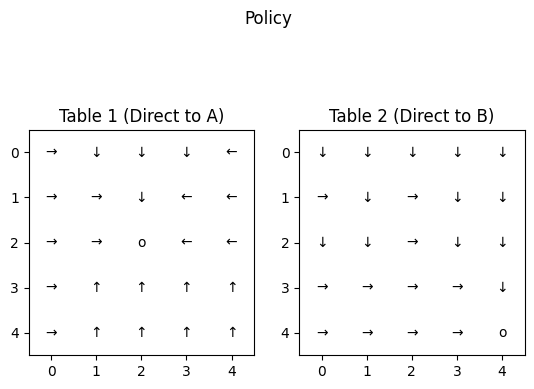

In [8]:
Visualization.plot_policy(env, learning, history)

- **Path Visualization**

To visualize the learning progress, we plot the path taken by the agent in a random run in the first evaluation episode and then a random run from the last episode. 

As you can see in the first episode, the agent will most likely get stuck moving back and forth over a small area, this is because during evaluation our target policy completely exploits the learnt Q table. Since in the first episode, it hasn't learnt much of anything getting stuck is to be expected.

However in the final episode, the agent performs impressively by executing the shortest path to first pick up A then go to B! This concretely shows the progress that has been made between the first and last evaluation episodes.

The plot is designed using interactive HTML environment so that it can animate the actions made by the agent sequentially to trace the path taken by the agent. 

Controls:
- Press the `>` button to move the animation forward
- Press `<` to reverse the animation
- Press the `+` button to speed up animation
- Press the `-` button to slow down animation

*Note: you can re-run the code block below to get a different random first and last evaluation episode*

*Note: since the agent path animation chooses a random evaluation configuration from the last episode it may not be the same one as the policy plot*

In [9]:
Visualization.plot_first_and_last_path_eval(eval_history)

- **Loss Graphs (Training)**

To visualize the performance of our model over time, we plot the losses over the number of episodes as a line graph. 

Note that The training loss does not appear to drop much during the course of training *because during training we heavily emphasize exploring,* this is why you see drastic fluctuations in the training losses

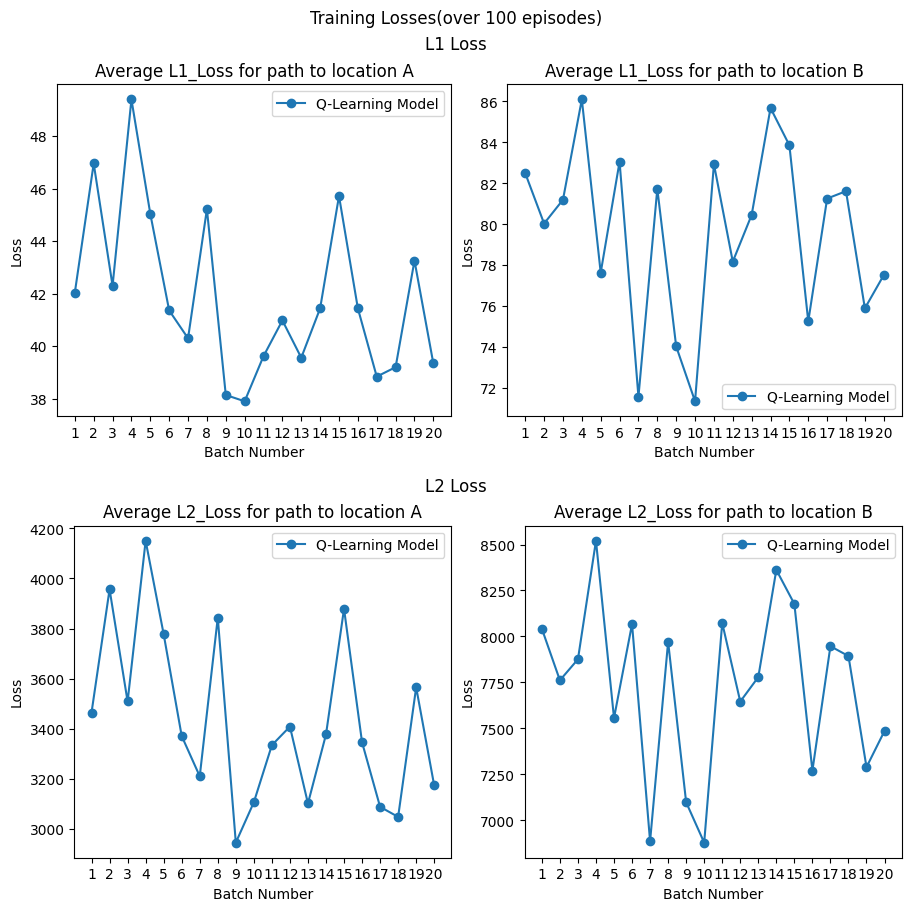

In [10]:
train_history_for_viz = {
    "Q-Learning Model": history
}

Visualization.plot_losses(train_history_for_viz)

- **Loss Graphs (Evaluation)**

On the other hand, looking at the evaluation losses we can see that they decrease monotonically as expected with slight fluctuation due to learning progress, this is because during evaluation, unlike during training, we fully exploit and do not explore, thus it is a more accurate indicator of how well our Q values have updated and the quick decline in losses strongly indicates that the model is steadily and quickly learning. 

Furthermore it converges fast and reaches a loss of 0 meaning that for all possible (agent, location A) configurations, the agent *always* takes the ideal path.

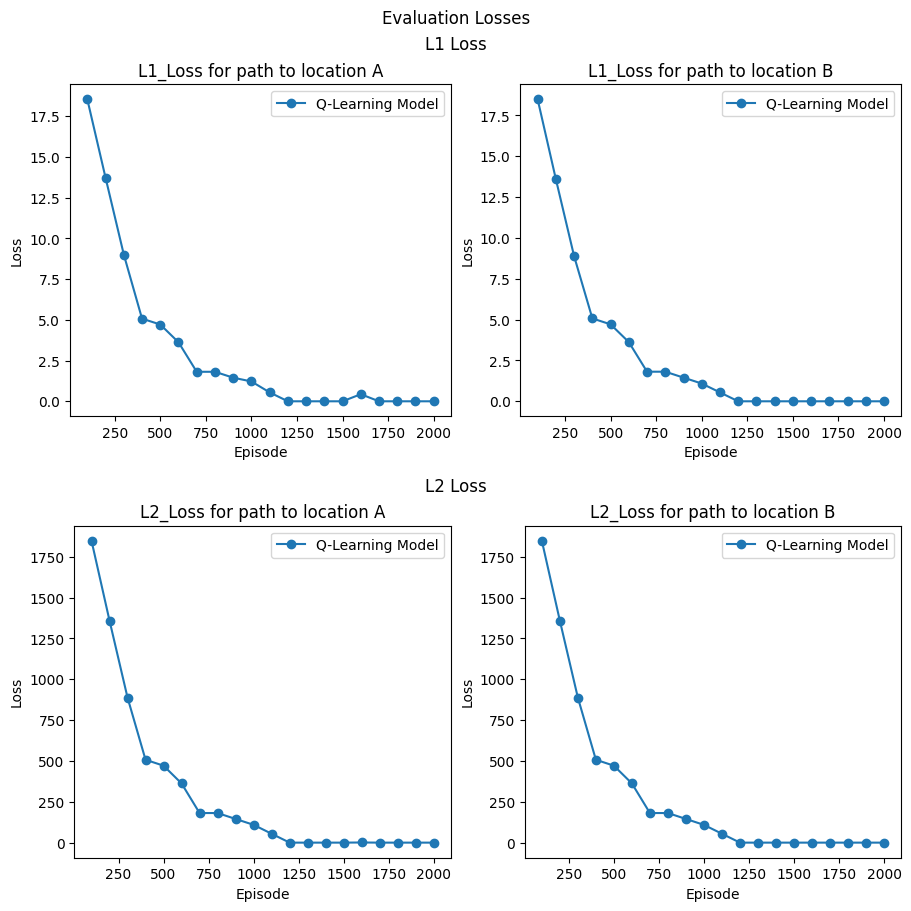

In [11]:
eval_history_for_viz = {
    "Q-Learning Model": eval_history
}

Visualization.plot_losses(eval_history_for_viz, train=False)

- **State & Q-Values Visualization**

As a reminder of our state space:
- Let (u, v) be state.  
- Let (x, y) be grid size.  

Based on our implementation:
1. u is the horizontal position of agent with respect to the target (A/B). u ∈ (-(x-1), (x-1))
2. v is the vertical position of the agent with respect to the target (A/B). v ∈ (-(y-1), (y-1))
3. Position of target relative to itself is at (0 ,0)  
  
To find how important a state is, we will show the summation of Q-Values of the action from adjacent states that lead to the state.  
  
From the plots below, we can see that all actions of all states lead to the reward at (0, 0). At the 3D plot, we can see that the corner point has a higher Q-value than its adjacent neighbours. However, let the neighbours be $b$, we note that there is a better adjacent neighbour, $c$, to $b$ other than the corner grid. With that, the policy is directed to the target location at (0, 0) even when the agent starts at corner location.

Our Q-Learning is successful.


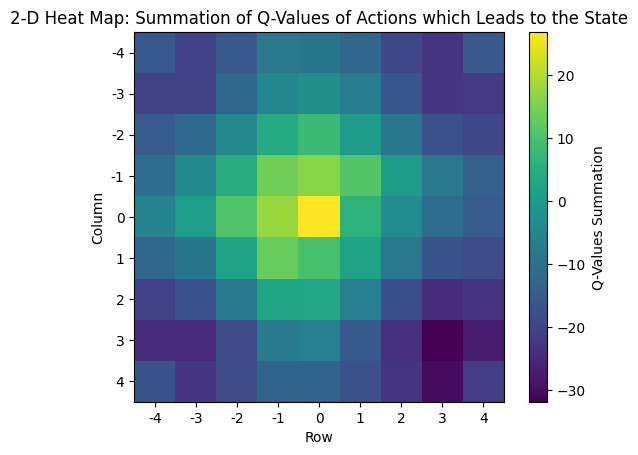

In [12]:
Visualization.plot_q_values_2d(learning)

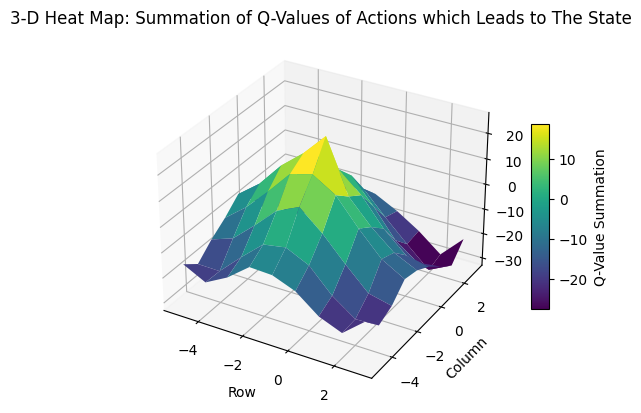

In [13]:
Visualization.plot_q_values_3d(learning)

# Scalability and Generalizability Testing

## Hyper-parameter Testing

Here we perform hyper-parameter testing to show that our solution is adaptive to many different parameter values.
In particular, here we train and evaluate a model for every combination of the following sets of hyperparameters:
- learning_rates = [0.1, 0.01, 0.001]
- gammas = [0.8, 0.9, 0.95, 0.99]
- policies = [EpsilonGreedy, Boltzmann, MonteCarlo, Pursuit]

After training and testing all these models, the best model for each policy (giving the lowest loss or converging the fastest) is chosen and their losses are plotted below

*Please note that running the following code cell will take upwards of 30mins depending on your computing power.*

For more details, please refer to the implementation:
- `hyperparam_search` (function to perform hyperparameter testing which will train and evaluate each model) located [**here**](modules/search.py)

In [14]:
np.random.seed(42)
random.seed(42)

[0.1, 0.01, 0.001]
[0.8, 0.9, 0.95, 0.99]
[<class 'modules.policies.EpsilonGreedy'>, <class 'modules.policies.Boltzmann'>, <class 'modules.policies.MonteCarlo'>, <class 'modules.policies.Pursuit'>]
testing with lr: 0.1, gamma: 0.8, policy: <class 'modules.policies.EpsilonGreedy'>
=====EVALUATION AT EPISODE 100: REWARD=-2725.44384057971=====
====EVALUATION AT EPISODE 100: LOSS=L1_Loss, VALUE=(25.753623188405797, 25.72463768115942)=====
====EVALUATION AT EPISODE 100: LOSS=L2_Loss, VALUE=(2572.521739130435, 2572.463768115942)=====
=====EVALUATION AT EPISODE 200: REWARD=-1646.7572463768115=====
====EVALUATION AT EPISODE 200: LOSS=L1_Loss, VALUE=(15.58695652173913, 15.579710144927537)=====
====EVALUATION AT EPISODE 200: LOSS=L2_Loss, VALUE=(1557.9855072463768, 1557.9710144927535)=====
=====EVALUATION AT EPISODE 300: REWARD=-1240.9746376811595=====
====EVALUATION AT EPISODE 300: LOSS=L1_Loss, VALUE=(11.78623188405797, 11.77536231884058)=====
====EVALUATION AT EPISODE 300: LOSS=L2_Loss, VALUE

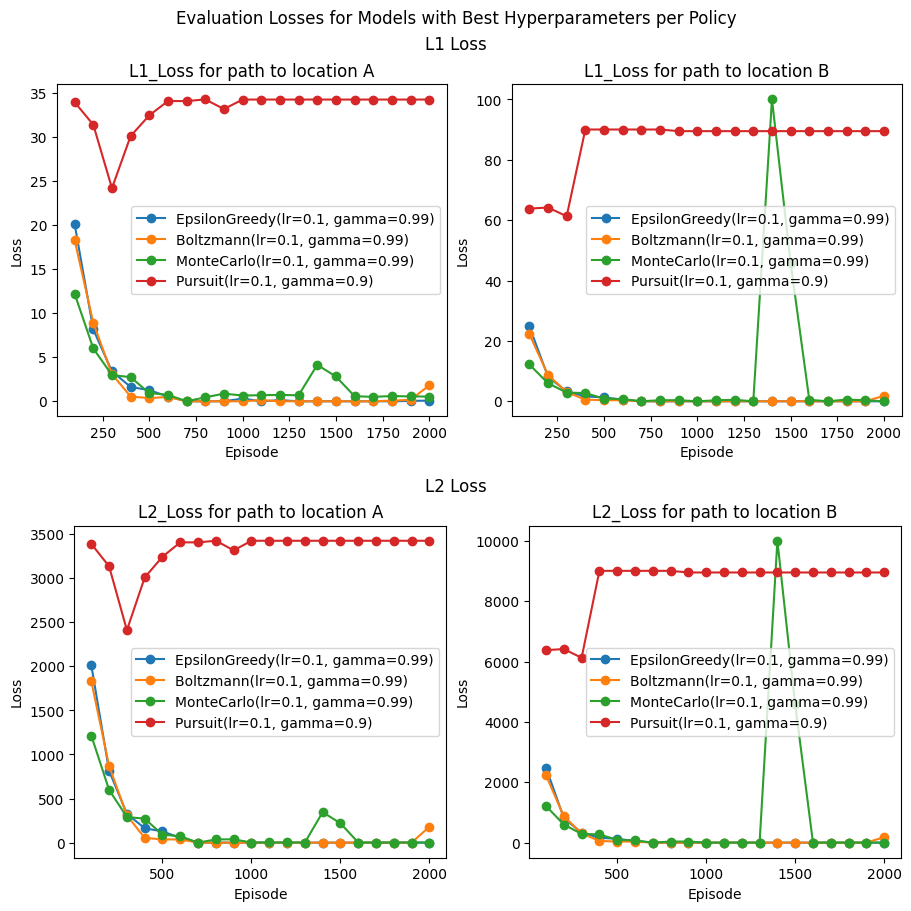

In [ ]:
hyperparam_search(save_to="hyperparam_search_res.pkl")

# NOTE: We have included the saved search results as a serialized .pkl file, 
# comment the line above and uncomment the line below to simply load these results and plot them
# hyperparam_search(load_from="hyperparam_search_res.pkl")

Due to the poor performance of Pursuit policy, we re-plot the graph but exclude Pursuit to better show the losses for the other models

[0.1, 0.01, 0.001]
[0.8, 0.9, 0.95, 0.99]
[<class 'modules.policies.EpsilonGreedy'>, <class 'modules.policies.Boltzmann'>, <class 'modules.policies.MonteCarlo'>, <class 'modules.policies.Pursuit'>]


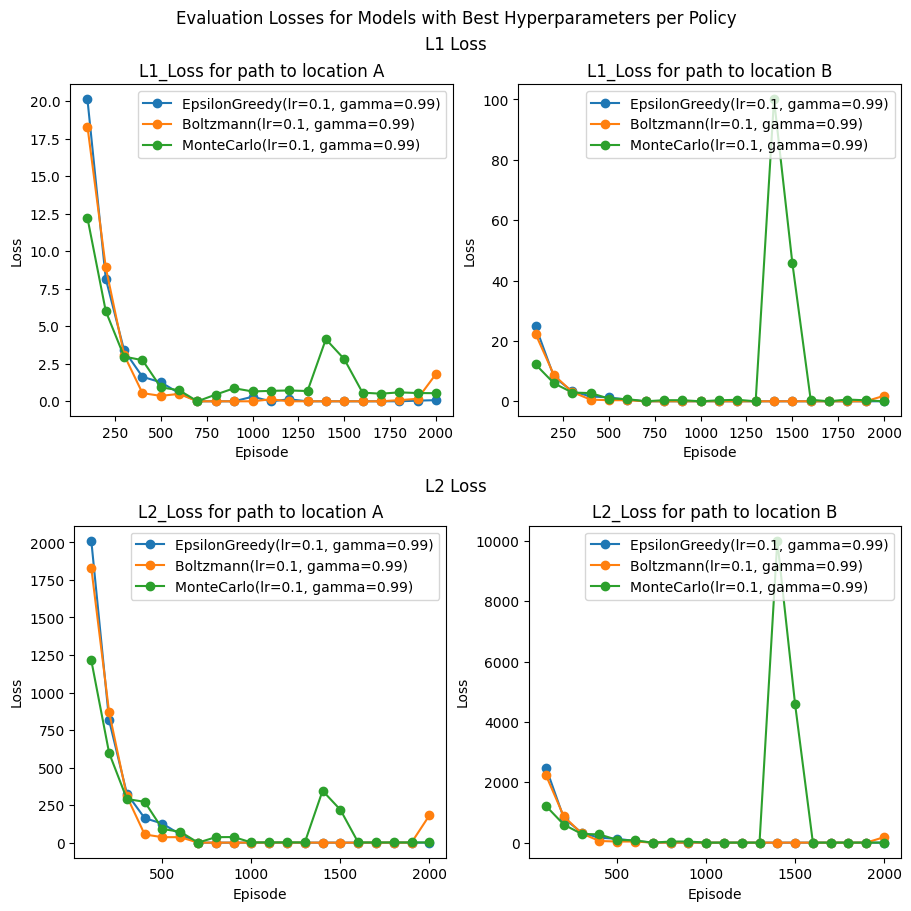

In [15]:
hyperparam_search(load_from="hyperparam_search_res.pkl", exclude=[Pursuit])

## Grid Size Testing

To show that our solution is adaptable to different sized grid worlds, below we have trained a separate model for the following grid world sizes:
- (3,3)
- (5,5)
- (6,6)
- (10,10)

Finally, we plot the losses for all 4 grid sizes and as expected, the larger the grid world the more the initial loss, and the slower the convergence, although there is a clear downward trend in all the grid worlds, proving that our method clearly learns even with different grid sizes.

For 3x3 grid worlds, the agent always executes the ideal path (because there is not much room to go anywhere else!), for 4x4 grid worlds, the agent has more difficulty incurring some losses in the beginning but quickly converges. Similarly, for 5x5 grid worlds, due to the larger state space, the agent incurs even more loss in the beginning and loss weans off slower. Finally for the 10x10 grid world, as expected due to the significantly larger state space, loss is much higher than all the rest and loss decreases much slower, in fact it even increases at episode 800, due to encountering rare scenarios in training.

*Note: the following code block may take a considerable amount of time to run ~10-15mins mainly due to the exhaustive evaluation for 10x10 grid world*

*Note-2: here we are only training for 1400 episodes and evaluating every 200 episodes, running for more episodes and evaluating more frequently will result in even better results*

For more details, please refer to the implementation:
- `test_grids` (function to perform model training and evaluation on different grid sizes) located [**here**](modules/grid_test.py)

In [18]:
np.random.seed(42)
random.seed(42)

[(3, 3), (5, 5), (6, 6), (10, 10)]
testing with grid size: (3, 3)
Episode 1 has total training rewards of -22
Episode 2 has total training rewards of -29
Episode 3 has total training rewards of -22
Episode 4 has total training rewards of -12
Episode 5 has total training rewards of 15
Episode 6 has total training rewards of -39
Episode 7 has total training rewards of -27
Episode 8 has total training rewards of -18
Episode 9 has total training rewards of 3
Episode 10 has total training rewards of -54
Episode 11 has total training rewards of -29
Episode 12 has total training rewards of 5
Episode 13 has total training rewards of -29
Episode 14 has total training rewards of -34
Episode 15 has total training rewards of 8
Episode 16 has total training rewards of -18
Episode 17 has total training rewards of 5
Episode 18 has total training rewards of -35
Episode 19 has total training rewards of 2
Episode 20 has total training rewards of -29
Episode 21 has total training rewards of -14
Episode 2

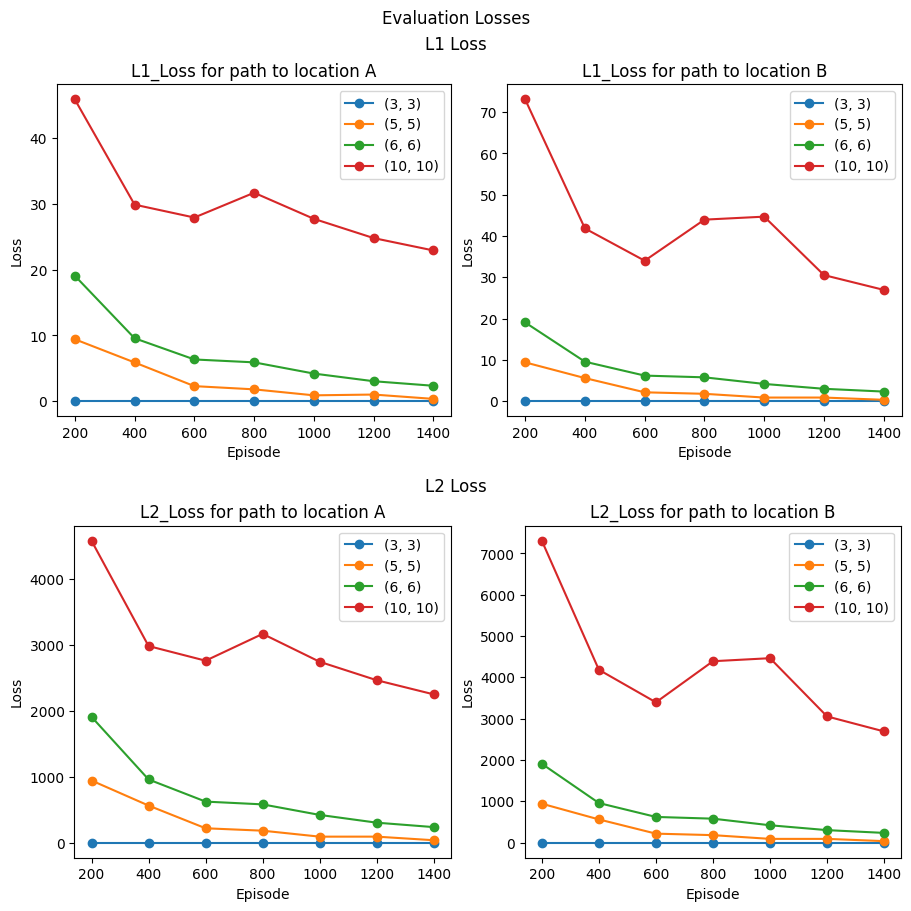

In [ ]:
results_grid = test_grids(save_to="grid_test.pkl")

# NOTE: we have included the grid test results as a serialized .pkl file, 
# comment the line above and uncomment the line below to simply load and plot these results
# results_grid = test_grids(load_from="grid_test.pkl")

To further prove this generalization to other grid world sizes, below we plot the policy visualization and agent path animation (for a random first and last evaluation episode) for all the grid world sizes.

Note: since the agent path animation chooses a random evaluation configuration from the last episode it may not be the same one as the policy plot

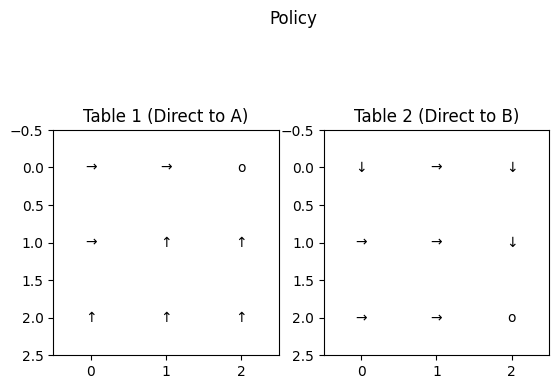

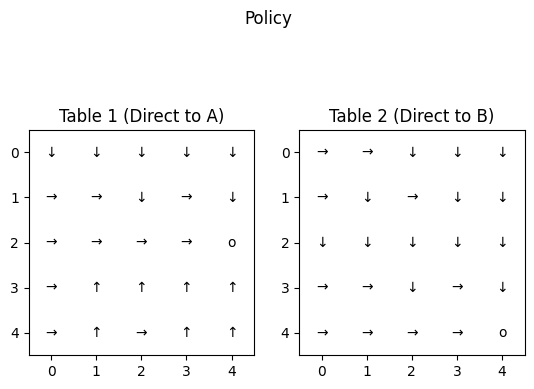

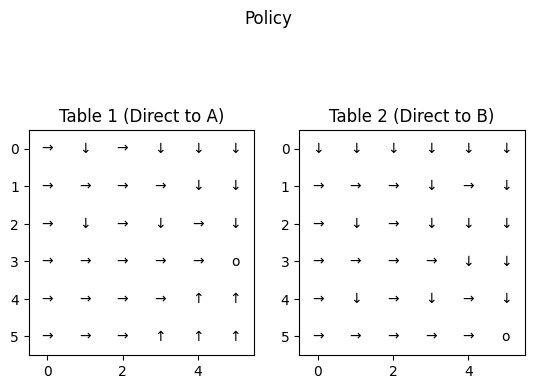

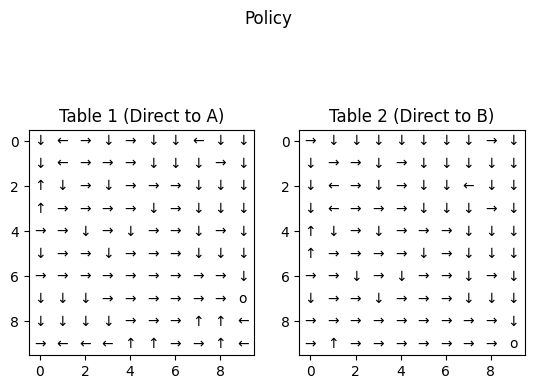

In [18]:
test_grids_viz(results_grid)

## Conclusion

In general, regardless of the behavioral policies, the learning of the agent would converge eventually and produce a generalised policy for locating the ideal path to point A followed by point B.

Since we randomly generate the positions of the agent and location A for each episode, and in addition, during evaluation of performance we test for every possible (agent, location A) combination, as can be seen by the quickly decreasing losses and eventual convergence, we have proven that it our solution is generalizable to any randomized agent position and/or location A.

It is noted that at the early stage of the training, the policy learnt by the agent is mostly contradicting and would lock itself into an infinite loop as shown in the above path tracing plot. This is mainly due to lack of understanding of the environment and agent is still in the process of exploration to find the best action given a state. With that, agent is most likely to lock itself in an infinite loop with minimal learning policy under full exploitation. To overcome this issue which happens commonly in early stage of evaluation, we have limit the maximum number of steps that an agent would take per episode. This would not only resolve the infinite loop issue but also direct the learning of the agent to take as minimum steps as possible. The applicability and effectiveness of such technique is witnessed after 2000 episodes where the agent could locate both point A and B with minimal number of steps.

From the policy visualisation above, it is noted that the policy learnt by the agent could be adapted to varying point A. By randomly sampling the location of point A and point B from the learning history, we note that regardless of the position, the policy could always evaluate the ideal path to both point A and point B. This is achievable via structuring the understanding of states in the agent. Instead of using the raw position on the grid as the state, we represent the state using Manhattan distance to create an afterstate learning effect. This would allow the agent to perceive the environment in a way that is reusable between episodes. Through the experiment, it is shown that such technique would allow the agent to learn better as compared to simple state space of using grid positions.

With various techniques implemented to structure the reward function, it is noted that the TARGET REWARD and BASE REWARD could be set as 1 and -1 respectively. However, by increasing the TARGET REWARD, the agent is more driven to move to point A and B. This would allow faster convergence as shown above. The target policy is mostly converged after 1000 episodes and can be adapted to all grid configurations as long as the agent, point A and point B are not overlapped.

As stated above, regardless of behavioral policy, the learning would eventually converge. However, some policies do perform better as compared to other policies. As an example, Pursuit policy requires longer time to learn the overall policy, i.e. after 3000 episodes while the other policies would converge within 1000 to 2000 episodes. This shows that behavioural policy significantly affect the learning progress of the agent. Selecting a good behavioral policy is essential for faster convergence to optimal policy which defines cost-effective solution.

From the hyperparameter testing, we note that Monte Carlo would converge much faster as compared to epsilon-greedy and boltzmann distribution policies. However, we note that Monte Carlo method would not be stable as there would be random spike happening at some point due to the high variance in Monte Carlo method. When there is a rare case happen which contradicts to the past learning experience, Monte Carlo would perform exploration then only exploitation. During exploration, the path taken by the agent is not optimal and hence resulting in the spike. Nevertheless, it still outperforms the other policies in terms of convergence speed in the expense of memory for extra Q-table. Note that the loss may fluctuate when policy is converged as there is still possibility for the agent to do exploration during training. From evaluation standpoint, once the policy is converged, the loss would stay constant, i.e. 0 for optimal policy.

Attention is drawn to the fact that all the policies would converge much faster when the discount factor is near to 1. This is because the TARGET REWARD is much higher than the BASE REWARD and PENALTY, driving the agent to the point A and B even during exploration. With that, convergence is more efficient with high discounting factor.

On the other hand, our method would allow fast convergence even though the grid size increases as shown in the plots above comparing model performance with different grid sizes. As expected, the larger the grid size the longer it takes the policy to converge, and when the grid size is increased to 10 x 10, the policy could not converge within 1500 episodes which is conventional since more exploration is needed to fully understand the environment due to the vast increase in state space.

Overall, our agent could learn the environment and produce a good policy in locating both point A and point B. However, without much resource management mechanisms applied, the learning of agent at a larger environment would be resource-consuming, particularly while the exhaustive evaluation gives a comprehensive measure of performance, it is not feasible to check for every single location in large grid worlds, a better solution would be smart random sampling from the state space and this would be the focus of our future work to implement a ***GREEN*** agent. 